In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [162]:
pd.options.display.max_rows = 1000

In [2]:
import os
import sys

releasy_module = os.path.abspath(os.path.join('..','..','..','dev','releasy2'))
if releasy_module not in sys.path:
    sys.path.insert(0, releasy_module)
    
import releasy
from releasy.miner_git import GitVcs
from releasy.miner import TagReleaseMiner, PathCommitMiner, RangeCommitMiner, TimeCommitMiner, VersionReleaseMatcher, TimeReleaseSorter


In [3]:
projects = pd.read_pickle('projects.zip')

In [180]:
releases = pd.DataFrame(columns=[
    "project","name", "lang","commits",
    "range_commits", "range_tpos", "range_fpos","range_fneg",
    "time_commits", "time_tpos", "time_fpos","time_fneg"])
    
count = 0
for i,project in enumerate(projects.itertuples()):
    path = os.path.abspath(os.path.join('..','..','..','repos2',project.name))
    
    try:
        print(f"{i+1:3} {project.name}")
        vcs = GitVcs(path)
        release_matcher = VersionReleaseMatcher()
        release_sorter = TimeReleaseSorter()
    
        release_miner = TagReleaseMiner(vcs, release_matcher, release_sorter)
        release_set = release_miner.mine_releases()

        path_miner = PathCommitMiner(vcs, release_set)
        range_miner = RangeCommitMiner(vcs, release_set)
        time_miner = TimeCommitMiner(vcs, release_set)
    
        print(f" - parsing by path")
        path_release_set = path_miner.mine_commits()
        print(f" - parsing by time")
        time_release_set = time_miner.mine_commits()
        print(f" - parsing by range")
        range_release_set = range_miner.mine_commits()
        
    
        stats = []
        for release in release_set:
            path_commits = set(path_release_set[release.name].commits)
            range_commits = set(range_release_set[release.name].commits)
            time_commits = set(time_release_set[release.name].commits)
    
            stats.append({
                "project": project.name,
                "name": release.name,
                "lang": project.lang,
                "commits": len(path_commits),
                "range_commits": len(range_commits),
                "range_tpos": len(path_commits & range_commits),
                "range_fpos": len(range_commits - path_commits),
                "range_fneg": len(path_commits - range_commits),
                "time_commits": len(time_commits),
                "time_tpos": len(path_commits & time_commits),
                "time_fpos": len(time_commits - path_commits),
                "time_fneg": len(path_commits - time_commits)
            })
        releases = releases.append(pd.DataFrame(stats))
    except Exception as e:
        print(f" - error: {e}")
    
releases_bkp = releases.copy()  

  1 vuejs/vue
 - parsing by path
 - parsing by time
 - parsing by range
  2 facebook/react
 - parsing by path
 - parsing by time
 - parsing by range
  3 twbs/bootstrap
 - parsing by path
 - parsing by time
 - parsing by range
  4 d3/d3
 - parsing by path
 - parsing by time
 - parsing by range
  5 facebook/react-native
 - parsing by path
 - parsing by time
 - parsing by range
  6 facebook/create-react-app
 - parsing by path
 - parsing by time
 - parsing by range
  7 nodejs/node
 - parsing by path
 - parsing by time
 - parsing by range
  8 mrdoob/three.js
 - parsing by path
 - parsing by time
 - parsing by range
  9 mui-org/material-ui
 - error: Repository not found at C:\Users\felipecrp\Research\Release\repos2\mui-org\material-ui
 10 angular/angular.js
 - error: Repository not found at C:\Users\felipecrp\Research\Release\repos2\angular\angular.js
 11 microsoft/vscode
 - error: Repository not found at C:\Users\felipecrp\Research\Release\repos2\microsoft\vscode
 12 denoland/deno
 - error:

In [181]:
# releases_bkp = releases.copy()
# releases = releases_bkp.copy()

In [182]:
releases = releases[releases.commits > 0].copy()

In [183]:
releases.range_tpos = pd.to_numeric(releases.range_tpos)
releases.range_fpos = pd.to_numeric(releases.range_fpos)
releases.range_fneg = pd.to_numeric(releases.range_fneg)
releases.time_tpos = pd.to_numeric(releases.time_tpos)
releases.time_fpos = pd.to_numeric(releases.time_fpos)
releases.time_fneg = pd.to_numeric(releases.time_fneg)

In [184]:
def precision(row, column):
    if row[column+"_tpos"] + row[column+"_fpos"] == 0:
        return 0.0
    else:
        return row[column+"_tpos"] / (row[column+"_tpos"] + row[column+"_fpos"])
    
def recall(row, column):
    if row[column+"_tpos"] + row[column+"_fneg"] == 0:
        return 0.0
    else:
        return row[column+"_tpos"] / (row[column+"_tpos"] + row[column+"_fneg"])


In [185]:
releases['range_precision'] = releases.apply(precision, args=('range',), axis=1)
releases['range_recall'] = releases.apply(recall, args=('range',), axis=1)
releases['time_precision'] = releases.apply(precision, args=('time',), axis=1)
releases['time_recall'] = releases.apply(recall, args=('time',), axis=1)

In [186]:
releases[releases['range_precision'] > 0.5].shape[0]

5456

In [187]:
releases[releases['time_recall'] < 1].shape

(2631, 16)

In [188]:
debug = False

p    rng  tme 


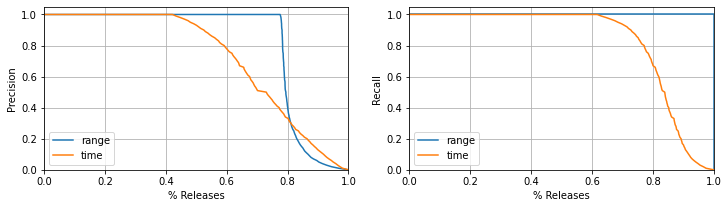

In [189]:
fig, (ap,ar) = plt.subplots(1,2)
fig.set_size_inches(12,3)
ap.set_xlabel("% Releases")
ap.set_ylabel("Precision")

ar.set_xlabel("% Releases")
ar.set_ylabel("Recall")

total = releases.shape[0]
increments = 0.01
y = []
x_precision_range = []
x_precision_time = []
x_recall_range = []
x_recall_time = []
print(f'{"p":4} {"rng":4} {"tme":4}')
for rng in np.arange(0, 1+increments, increments):
    range_precision_percent = releases[releases['range_precision'] >= rng].shape[0] / total 
    time_precision_percent = releases[releases['time_precision'] >= rng].shape[0] / total 
    range_recall_percent = releases[releases['range_recall'] >= rng].shape[0] / total 
    time_recall_percent = releases[releases['time_recall'] >= rng].shape[0] / total 
    x_precision_range.append(range_precision_percent)
    x_precision_time.append(time_precision_percent)
    x_recall_range.append(range_recall_percent)
    x_recall_time.append(time_recall_percent)
    
    y.append(rng)
    print(f"{y[-1]:4.2f} {x_range[-1]:4.2f} {x_time[-1]:4.2f}") if debug else None

y.append(1)
x_precision_range.append(0)
x_precision_time.append(0)
x_recall_range.append(0)
x_recall_time.append(0)
ap.plot(x_precision_range,y, label='range')
ap.plot(x_precision_time,y, label='time')
ap.legend(loc='lower left')
ap.set_xlim((0,1))
ap.set_ylim((0,1.05))
ap.xaxis.grid()
ap.yaxis.grid()

ar.plot(x_recall_range,y, label='range')
ar.plot(x_recall_time,y, label='time')
ar.legend(loc='lower left')
ar.set_xlim((0,1))
ar.set_ylim((0,1.05))
ar.xaxis.grid(which='both')
ar.yaxis.grid()

p    rng  tme 


(0.0, 1.05)

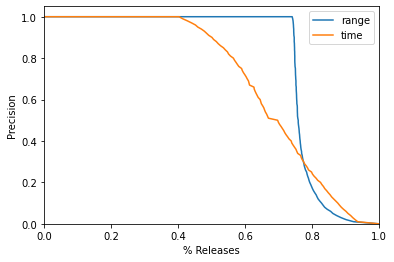

In [147]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
ax.set_xlabel("% Releases")
ax.set_ylabel("Precision")

total = releases.shape[0]
increments = 0.01
y = []
x_range = []
x_time = []
print(f'{"p":4} {"rng":4} {"tme":4}')
for rng in np.arange(0, 1+increments, increments):
    range_percent = releases[releases['range_precision'] >= rng].shape[0] / total 
    time_percent = releases[releases['time_precision'] >= rng].shape[0] / total 
    x_range.append(range_percent)
    x_time.append(time_percent)
    y.append(rng)
    print(f"{y[-1]:4.2f} {x_range[-1]:4.2f} {x_time[-1]:4.2f}") if debug else None

y.append(1)
x_range.append(0)
x_time.append(0)
ax.plot(x_range,y, label='range')
ax.plot(x_time,y, label='time')
ax.legend()
ax.set_xlim((0,1))
ax.set_ylim((0,1.05))


p    rng  tme 


(0.0, 1.05)

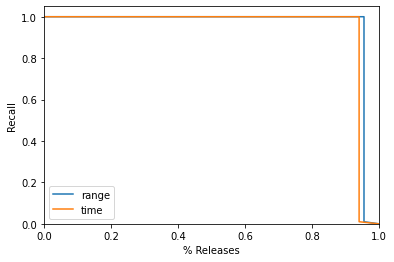

In [148]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
ax.set_xlabel("% Releases")
ax.set_ylabel("Recall")

total = releases.shape[0]
increments = 0.01
y = []
x_range = []
x_time = []
print(f'{"p":4} {"rng":4} {"tme":4}')
for rng in np.arange(0, 1+increments, increments):
    range_percent = releases[releases['range_recall'] >= rng].shape[0] / total 
    time_percent = releases[releases['time_recall'] >= rng].shape[0] / total 
    x_range.append(range_percent)
    x_time.append(time_percent)
    y.append(rng)
    print(f"{y[-1]:4.2f} {x_range[-1]:4.2f} {x_time[-1]:4.2f}") if debug else None

y.append(1)
x_range.append(0)
x_time.append(0)
ax.plot(x_range,y, label='range')
ax.plot(x_time,y, label='time')
ax.legend()
ax.set_xlim((0,1))
ax.set_ylim((0,1.05))
    


In [58]:
y

[0.0,
 0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.8500000000000001,
 0.9,
 0.9500000000000001,
 1.0]

In [57]:
x

[0.955543206446235,
 0.8626007224228952,
 0.828285634898583,
 0.8081411503195332,
 0.792720200055571,
 0.7827174215059739,
 0.7742428452347875,
 0.7689636010002778,
 0.7645179216449014,
 0.7618782995276465,
 0.7579883300916921,
 0.7564601278132814,
 0.7543762156154488,
 0.7531258682967491,
 0.751736593498194,
 0.7500694637399278,
 0.7488191164212281,
 0.7481244790219506,
 0.7467352042233953,
 0.7450680744651292,
 0.0]

In [30]:
releases[releases.range_precision < 1].shape

(1864, 16)

In [32]:
releases[releases.range_recall < 1].shape

(320, 16)

In [31]:
releases[releases.time_precision < 1].shape

(4297, 16)

In [33]:
releases[releases.time_recall < 1].shape

(425, 16)

In [35]:
releases.dtypes

project             object
name                object
lang                object
commits             object
range_commits       object
range_tpos           int64
range_fpos           int64
range_fneg           int64
time_commits        object
time_tpos            int64
time_fpos            int64
time_fneg            int64
range_precision    float64
range_recall       float64
time_precision     float64
time_recall        float64
dtype: object

In [54]:
rlang_df = releases_df.groupby(['lang']).sum()
rlang_df['precision'] = rlang_df.apply(precision, axis=1)
rlang_df['recall'] = rlang_df.apply(recall, axis=1)

In [75]:
#rlang_df.to_csv('rlang.csv')
rlang_df

,fpos,fneg,tpos,precision,recall
lang,,,,,
c,11796,133598,32696,0.734874,0.196616
c#,1946,31966,17320,0.898993,0.351418
c++,5856,110906,5332,0.476582,0.045871
go,22877,64382,37229,0.619389,0.366387
java,32884,2601684,41995,0.560838,0.015885
javascript,45753,1465681,78094,0.630568,0.050586
php,13515,752975,24884,0.648038,0.031990
python,5102,59311,21215,0.806133,0.263455
ruby,4910,295170,32312,0.868089,0.098668


In [73]:
releases_df.loc[:,['project','lang']].drop_duplicates().to_csv('p.csv')

In [57]:
rproj_df = releases_df.groupby(['project']).sum()
rproj_df['precision'] = rproj_df.apply(precision, axis=1)
rproj_df['recall'] = rproj_df.apply(recall, axis=1)

In [87]:
releases_df[(releases_df.project == 'Homebrew/brew') & (releases_df.precision < 1.0)].sort_values(['precision'], ascending=False)

,project,name,lang,path_commits,time_commits,fpos,fneg,tpos,precision,recall
151,Homebrew/brew,0.9.8,ruby,4892,4896,4,0,4892,0.999183,1.000000
163,Homebrew/brew,0.5,ruby,332,333,1,0,332,0.996997,1.000000
161,Homebrew/brew,0.7,ruby,270,271,1,0,270,0.996310,1.000000
162,Homebrew/brew,0.6,ruby,165,165,1,1,164,0.993939,0.993939
69,Homebrew/brew,1.7.2,ruby,327,312,2,17,310,0.993590,0.948012
...,...,...,...,...,...,...,...,...,...,...
134,Homebrew/brew,1.1.5,ruby,2295,3,1,2293,2,0.666667,0.000871
96,Homebrew/brew,1.5.8,ruby,5,3,1,3,2,0.666667,0.400000
8,Homebrew/brew,2.4.1,ruby,1626,128,45,1543,83,0.648438,0.051046
4,Homebrew/brew,2.4.5,ruby,2025,90,35,1970,55,0.611111,0.027160


In [86]:
rproj_df[rproj_df.precision > rproj_df.recall]

,fpos,fneg,tpos,precision,recall
project,,,,,
zxing/zxing,2,5396,3501,0.999429,0.393503
netdata/netdata,47,5718,10812,0.995672,0.654083
ShareX/ShareX,66,1177,5859,0.988861,0.832717
gogs/gogs,109,9404,5002,0.978673,0.347216
soimort/you-get,60,954,2248,0.974003,0.702061
keras-team/keras,140,5278,5203,0.973797,0.496422
ggreer/the_silver_searcher,79,3676,1918,0.960441,0.342867
Homebrew/brew,878,264587,21099,0.960049,0.073854
facebook/jest,254,2190,4693,0.948656,0.681825


In [77]:
#rproj_df.to_csv('rproj.csv')
rproj_df.sort_values(['precision'], ascending=False)

,fpos,fneg,tpos,precision,recall
project,,,,,
0xd4d/dnSpy,0,0,3890,1.000000,1.000000
zxing/zxing,2,5396,3501,0.999429,0.393503
netdata/netdata,47,5718,10812,0.995672,0.654083
ShareX/ShareX,66,1177,5859,0.988861,0.832717
gogs/gogs,109,9404,5002,0.978673,0.347216
soimort/you-get,60,954,2248,0.974003,0.702061
keras-team/keras,140,5278,5203,0.973797,0.496422
ggreer/the_silver_searcher,79,3676,1918,0.960441,0.342867
Homebrew/brew,878,264587,21099,0.960049,0.073854


In [9]:
count = 0
for project in projects.itertuples():
    path = os.path.abspath(os.path.join('..','..','..','repos2',project.name))
    try:
        vcs = GitVcs(path)
    except:
        print(f"error on {project.name}")
        count+=1
print(count)

error on mui-org/material-ui
error on angular/angular.js
error on microsoft/vscode
error on denoland/deno
error on microsoft/TypeScript
error on ant-design/ant-design
error on storybookjs/storybook
error on ionic-team/ionic-framework
error on elastic/elasticsearch
error on ReactiveX/RxJava
error on PhilJay/MPAndroidChart
error on ytdl-org/youtube-dl
error on django/django
error on ansible/ansible
error on scikit-learn/scikit-learn
error on home-assistant/core
error on fzaninotto/Faker
error on symfony/symfony
error on composer/composer
error on bcit-ci/CodeIgniter
error on Seldaek/monolog
error on sebastianbergmann/phpunit
error on briannesbitt/Carbon
error on electron/electron
error on opencv/opencv
error on bitcoin/bitcoin
error on pytorch/pytorch
error on tesseract-ocr/tesseract
error on x64dbg/x64dbg
error on godotengine/godot
error on BVLC/caffe
error on PowerShell/PowerShell
error on dotnet/aspnetcore
error on Wox-launcher/Wox
error on dotnet/roslyn
error on dotnet/efcore
error o

In [ ]:
releases_df